In [1]:
from __future__ import print_function

#import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

import os
cwd = os.getcwd()

/home/carlos/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Import Content and Style Images

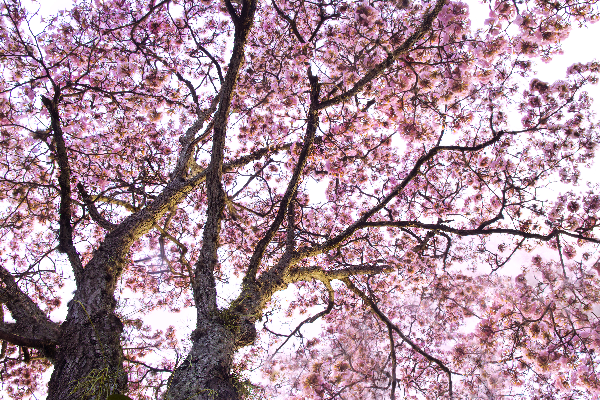

In [2]:
height = 400
width  = 600
cnt_name = 'guayacan'
content_image_path = cwd + '/content/' + cnt_name + '.jpg'
content_image = Image.open(content_image_path)
content_image = content_image.resize((width, height))
content_image

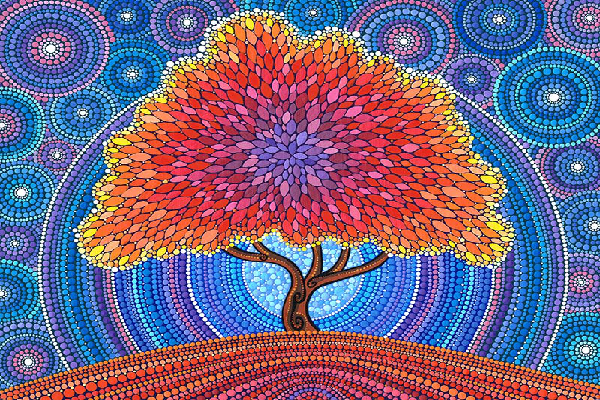

In [7]:
sty_name = 'puntos'
style_image_path = cwd + '/style/' + sty_name + '.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((width, height))
style_image

### Add dimension for batch processing

In [8]:
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 400, 600, 3)
(1, 400, 600, 3)


### Mean Substraction and  RGB to BGR

In [9]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

### Tensorflow Graph

In [10]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

In [11]:
input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)

### Import VGG16 CNN

In [12]:
model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)

### Layers of the model

In [13]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 400, 600, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 400, 600, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 200, 300, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 200, 300, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 200, 300, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 100, 150, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 100, 150, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 100, 150, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 100, 150, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 50, 75, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(3, 50, 75, 512) dtype=float32>,
 'b

### Weights for final image

In [14]:
content_weight = 0.1
style_weight = 10.0
total_variation_weight = 2.0

### Content loss function

For the content and combination image compute the features of a specified convolution layer. The content loss is defined as the distance of these two sets of features. 

In [15]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [16]:
loss = backend.variable(0.)
def content_loss(content, combination):
    channels = 3
#    size = height * width
#    S = gram_matrix(combination)
#    C = gram_matrix(content)
    return backend.sum(backend.square(combination - content)) #+ 20*backend.sum(backend.square(S - C)) / (4. * (channels**2 ) * (size **2))

feature_layers = ['block2_conv2','block4_conv2','block4_conv1','block3_conv1', 'block3_conv2']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    content_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    #sl = style_loss(content_features, combination_features)
    loss += (content_weight / len(feature_layers))# * sl



content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(content_image_features,
                                      combination_features)

### Gram Matrix: $G(X) =  XX^T$

In [17]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

### Style loss

In [18]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2)) #+ 0.005*content_loss(style, combination)

feature_layers = ['block1_conv2', 'block2_conv2', 'block3_conv1', 'block4_conv3',
                  'block2_conv1']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

### Total loss: 
#### $\alpha \, \mathcal{L}(\text{combination_image, content}) + \beta \, \mathcal{L}(\text{combination_image, style})$

In [19]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

### Gradients

In [20]:
grads = backend.gradients(loss, combination_image)

### Evaluator to compute loss and gradients on each iteration

In [21]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

### Minimize loss

Start of iteration 0
Current loss value: 906994840000.0
Iteration 0 completed in 4s
Start of iteration 1
Current loss value: 378643550000.0
Iteration 1 completed in 3s
Start of iteration 2
Current loss value: 287000850000.0
Iteration 2 completed in 3s
Start of iteration 3
Current loss value: 258675870000.0
Iteration 3 completed in 3s
Start of iteration 4
Current loss value: 242362610000.0
Iteration 4 completed in 3s
Start of iteration 5
Current loss value: 233845670000.0
Iteration 5 completed in 3s
Start of iteration 6
Current loss value: 227873910000.0
Iteration 6 completed in 3s
Start of iteration 7
Current loss value: 224227500000.0
Iteration 7 completed in 3s
Start of iteration 8
Current loss value: 221486280000.0
Iteration 8 completed in 3s
Start of iteration 9
Current loss value: 219208430000.0
Iteration 9 completed in 3s


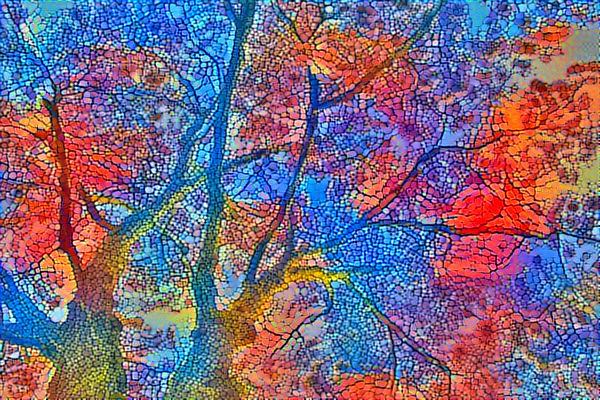

In [18]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.
iterations = 10
X = np.zeros((iterations,height,width,3))

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    X[i,...] = x.reshape((height, width, 3))
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))
    
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 104
x[:, :, 1] += 117
x[:, :, 2] += 124
x = np.clip(x, 0, 255).astype('uint8')

final_img = Image.fromarray(x).resize((width, height))
final_img

In [21]:
imsave('results/' + cnt_name + '-' + sty_name + str(content_weight) + '03.jpg', final_img)

/home/carlos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  """Entry point for launching an IPython kernel.


In [25]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128
X = np.zeros((iterations,height,width,3))

iterations = 10 
def img_merge(iterations,cnt_layers,sty_layers):
    x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.
    X = np.zeros((iterations,height,width,3))

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                    fprime=evaluator.grads, maxfun=20)
    X[i,...] = x.reshape((height, width, 3))
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 913593600000.0
Iteration 0 completed in 3s
Start of iteration 1
Current loss value: 394113160000.0
Iteration 1 completed in 3s
Start of iteration 2
Current loss value: 290601570000.0
Iteration 2 completed in 3s
Start of iteration 3
Current loss value: 256426600000.0
Iteration 3 completed in 3s
Start of iteration 4
Current loss value: 242347030000.0
Iteration 4 completed in 3s
Start of iteration 5
Current loss value: 233930130000.0
Iteration 5 completed in 3s
Start of iteration 6
Current loss value: 227913270000.0
Iteration 6 completed in 3s
Start of iteration 7
Current loss value: 224552570000.0
Iteration 7 completed in 3s
Start of iteration 8
Current loss value: 221824250000.0
Iteration 8 completed in 3s
Start of iteration 9
Current loss value: 219799190000.0
Iteration 9 completed in 3s


In [36]:
#X = X.reshape((height, width, 3))
#X = X[:, :, ::-1]
X[:, :, 0] += 104
X[:, :, 1] += 117
X[:, :, 2] += 124
X = np.clip(X, 0, 255).astype('uint8')

In [1]:
final_img = Image.fromarray(X[0,...]).resize((width, height))
final_img

NameError: name 'Image' is not defined